Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    ax.grid(alpha=0.5)
    return ax

In [17]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

In [4]:
band = 'g'
field = 'south'
region_name = 'decals_ngc'

if (field=='north') and ((band=='g') or (band=='r')):
    pixscale_native = 0.454
else:
    pixscale_native = 0.262
# pixscale = 0.262 # pixscale for cutout queries

In [5]:
ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec']

# ccd = fitsio.read('/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9.fits.gz')
if field=='south':
    ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-decam-dr8.fits.gz', columns=ccd_columns)
elif field=='north' and band=='z':
    ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-mosaic-dr8.fits.gz', columns=ccd_columns)
elif field=='north' and (band=='g' or band=='r'):
    ccd = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-90prime-dr8.fits.gz', columns=ccd_columns)
else:
    raise ValueError
ccd = Table(ccd)
ccd[:1]

image_filename,image_hdu,camera,expnum,ccdname,filter,fwhm,ra,dec
bytes120,int16,bytes9,int64,bytes5,bytes1,float32,float64,float64
decam/CPDES82/c4d_130901_031805_ooi_g_v1.fits.fz,1,decam,229341,S29,g,5.31041,318.050324504,1.70306451119


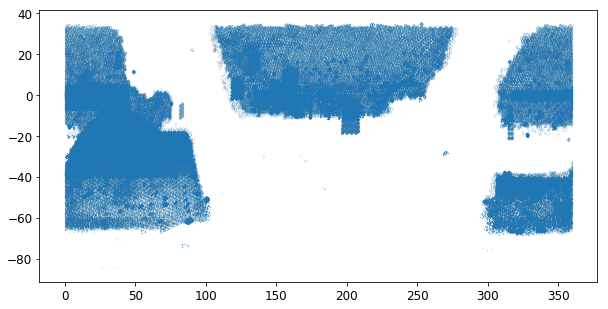

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(ccd['ra'][::10], ccd['dec'][::10], '.', ms=0.1)
plt.show()

In [7]:
if (field=='north') and ((band=='g') or (band=='r')):
    pixscale_native = 0.454
else:
    pixscale_native = 0.262
# pixscale = 0.262 # pixscale for cutout queries

tmp = np.loadtxt('../data/{}_poly_fit.txt'.format(region_name))
band_index = np.where(band==np.array(['g', 'r', 'z']))[0][0]
poly = np.poly1d(tmp[band_index])
print(poly)
profile_fit = np.poly1d(poly)

        5          4         3         2
-0.077 x - 0.2577 x + 1.984 x - 2.181 x - 3.396 x - 2.231


__Check that the fit works__

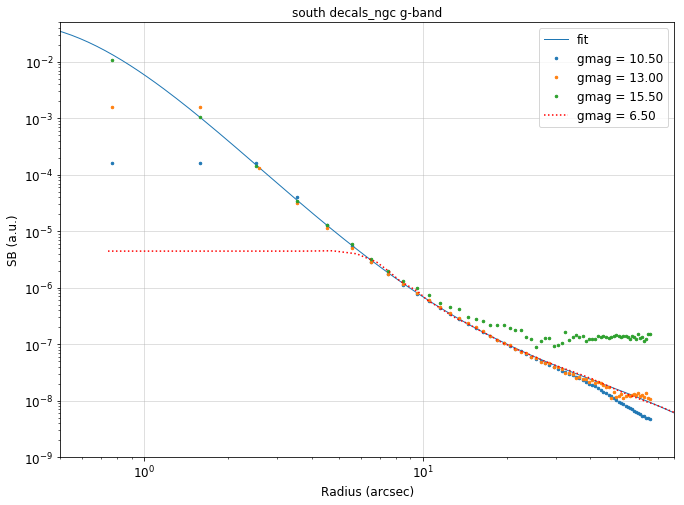

In [8]:
ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]
ls_mag_bright = 6.5

profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, region_name, band), format='ascii.commented_header')
indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, region_name, band))

profile_bright = Table.read('../data/average_profiles_{}_{}_{}-bright.txt'.format(field, region_name, band), format='ascii.commented_header')
indiv_bright = Table.read('../data/individual_profiles_{}_{}_{}-bright.fits'.format(field, region_name, band))

xfit = np.logspace(-1, 2, 200)
yfit = 10**(profile_fit(np.log10(xfit)))

plt.figure(figsize=(11, 8))
plt.loglog(xfit, yfit, '-', lw=1., alpha=1., 
           label='fit', c='C0')
# for index in range(len(ls_mag_bins)):
for index in [0, 2, 4]:
    # normalize the flux to 22.5 magnitude stars
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
               label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]))
norm = 10**((ls_mag_bright-22.5)/2.5) * pixscale_native**2
x = profile_bright['radius_{}_{:.2f}'.format(band, ls_mag_bright)]
y = norm * profile_bright['flux_{}_{:.2f}'.format(band, ls_mag_bright)]
plt.loglog(x, y, lw=1.5, alpha=1., ls=':',
           label='{}mag = {:.2f}'.format(band, ls_mag_bright), c='r')
plt.title('{} {} {}-band'.format(field, region_name, band))
plt.axis([0.5, 80, 1e-9, 5e-2])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.legend()
plt.show()

--------

In [9]:
ccd_mask = ccd['filter']==band
# ccd_mask &= (ccd['ra']>ra-dra) & (ccd['ra']<ra+dra) & (ccd['dec']>dec-ddec) & (ccd['dec']<dec+ddec)
ccd_mask &= (ccd['dec']<33) & (ccd['dec']>-30)
print(np.sum(ccd_mask))

idx = np.where(ccd_mask)[0]
nplot = 20
if len(idx)>nplot:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nplot, replace=False)

1907768


In [10]:
ccd_index = idx[0]

expnum = ccd['expnum'][ccd_index]
ccdname = ccd['ccdname'][ccd_index]

print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))

expnum_str = str(expnum)
if field=='south':
    fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
elif field=='north' and band=='z':
    fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/mosaic/psfex-merged/{}/mosaic-{}.fits'.format((5-len(expnum_str[:-3]))*'0'+expnum_str[:-3], (8-len(expnum_str))*'0'+expnum_str)
elif field=='north' and (band=='g' or band=='r'):
    fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/90prime/psfex-merged/{}/90prime-{}.fits'.format(expnum_str[:5], (8-len(expnum_str))*'0'+expnum_str)
else:
    raise ValueError
hdu = fits.open(fn)
data = hdu[1].data
# print(data['psf_mask'].shape)

which_ccd = np.where(data['ccdname']==ccdname)[0][0]
psf = data['psf_mask'][which_ccd]
# print(psf.shape)

psf0 = psf[0]
# normalize to a 22.5 magnitude star
# print(np.sum(psf0))
psf0 = psf0/np.sum(psf0)

grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
xx, yy = np.meshgrid(grid, grid)
radius_grid = np.sqrt(xx**2 + yy**2)
radius = radius_grid.flatten()

281786 N9 g; FWHM = 1.04


In [11]:
psf = (psf0).flatten()

mask = radius<3.5
radius = radius[mask]
psf = psf[mask]

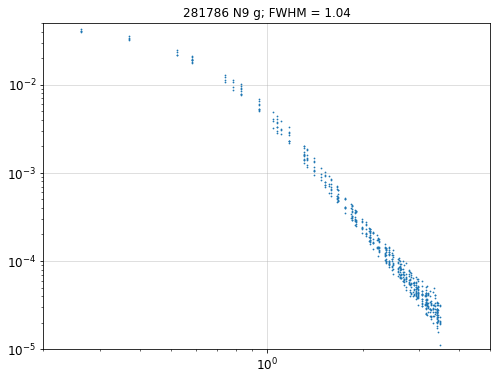

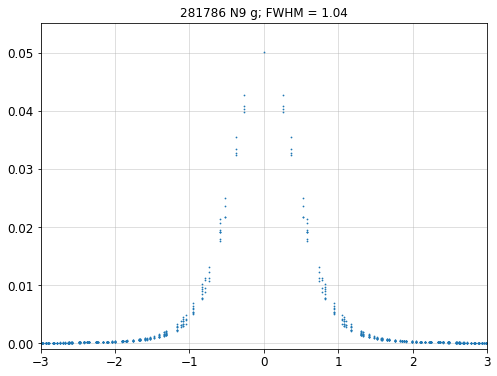

In [12]:
mask = radius>0
psf_mirror = np.concatenate([psf[mask][::-1], psf])
radius_mirror = np.concatenate([-radius[mask][::-1], radius])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(8, 6))
    plt.loglog(radius, psf, '.', ms=1.5)
    plt.axis([0.2, 5, 1e-5, 0.05])
    plt.grid(alpha=0.5)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.plot(radius_mirror, psf_mirror, '.', ms=1.5)
    plt.axis([-3, 3, -0.001, psf.max()*1.1])
    plt.grid(alpha=0.5)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))
    plt.show()

In [14]:
radius_arr = np.linspace(0, 3, 61)
flux_frac = np.zeros(len(radius_arr))
for index in range(len(radius_arr)):
    flux_frac[index] = np.sum(psf[radius<radius_arr[index]])/np.sum(psf)

[ 0.9366461   3.15866916]


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


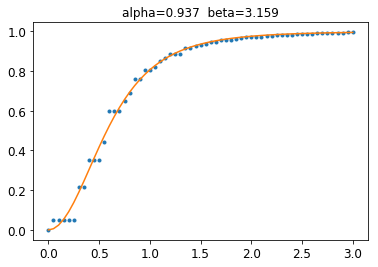

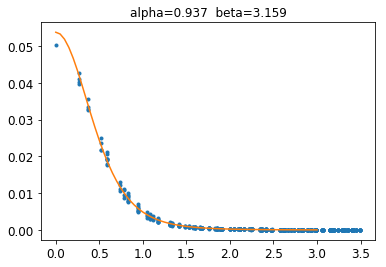

In [15]:
popt, pcov = curve_fit(get_frac_moffat, radius_arr, flux_frac)
print(popt)

# alpha = 0.8
# beta = 1.9
alpha, beta = popt
flux_frac_fit = get_frac_moffat(radius_arr, alpha, beta)
psf_moffat_fit = pixscale_native**2 * get_sb_moffat(radius_arr, alpha, beta)

plt.plot(radius_arr, flux_frac, '.')
plt.plot(radius_arr, flux_frac_fit)
plt.title('alpha={:.3f}  beta={:.3f}'.format(alpha, beta))
plt.show()

plt.plot(radius, psf, '.')
plt.plot(radius_arr, psf_moffat_fit)
plt.title('alpha={:.3f}  beta={:.3f}'.format(alpha, beta))
plt.show()

281786 N9 g; FWHM = 1.04


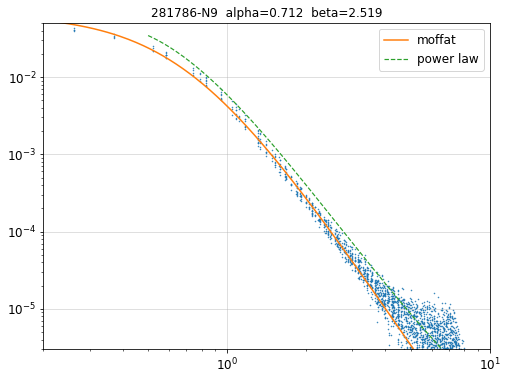

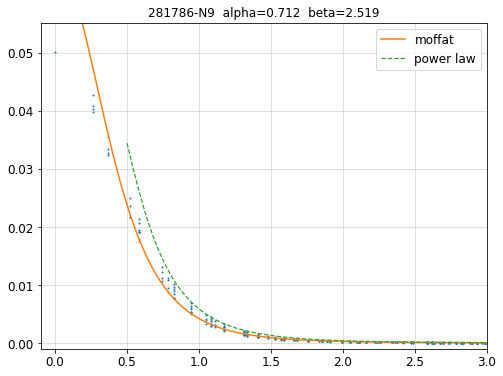

515808 S29 g; FWHM = 1.29


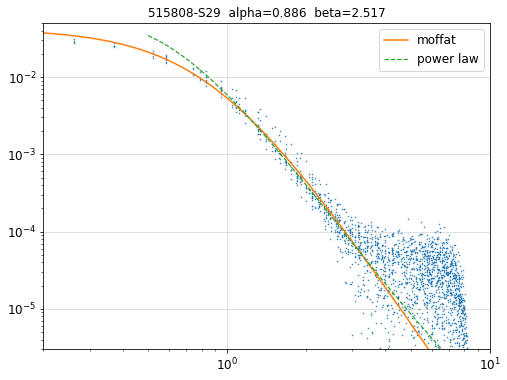

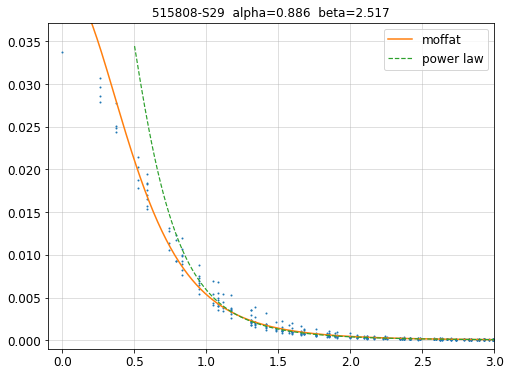

695309 N13 g; FWHM = 1.27


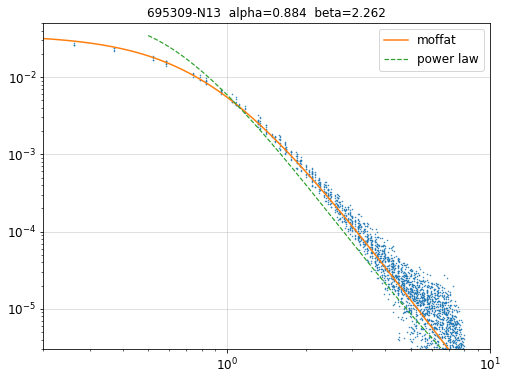

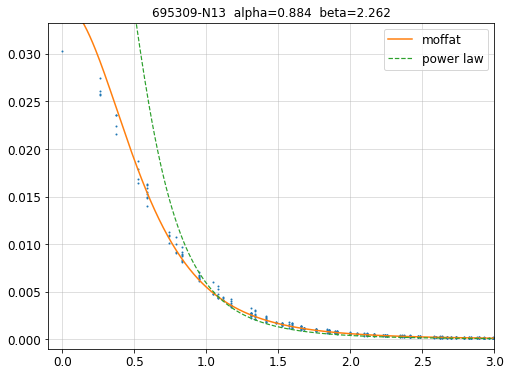

172318 S4 g; FWHM = 1.29


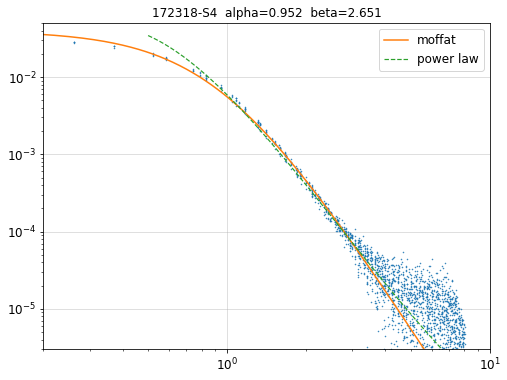

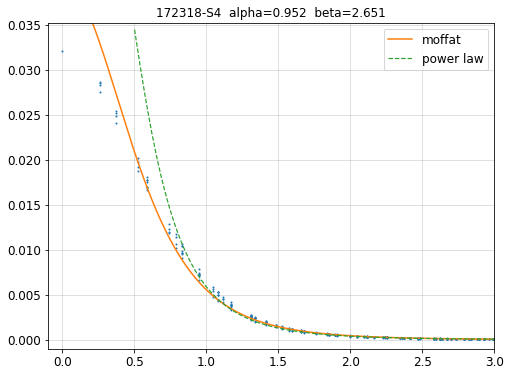

449111 N13 g; FWHM = 1.30


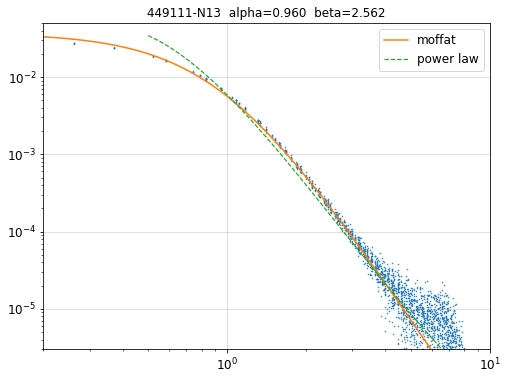

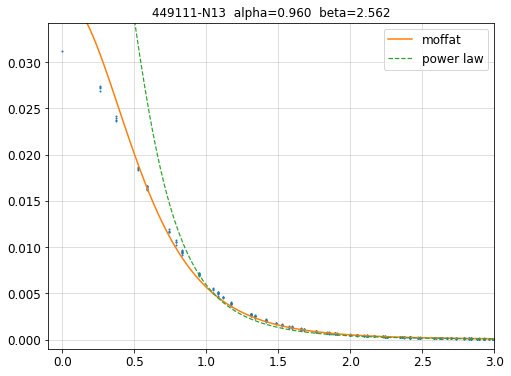

449715 S1 g; FWHM = 1.58


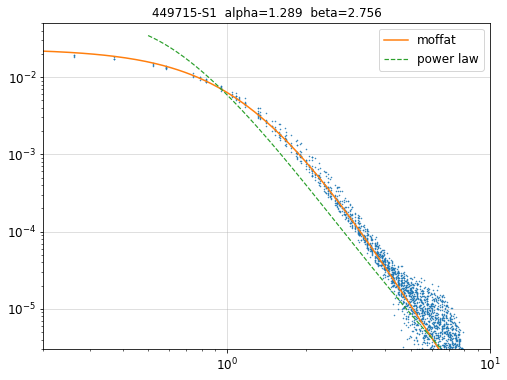

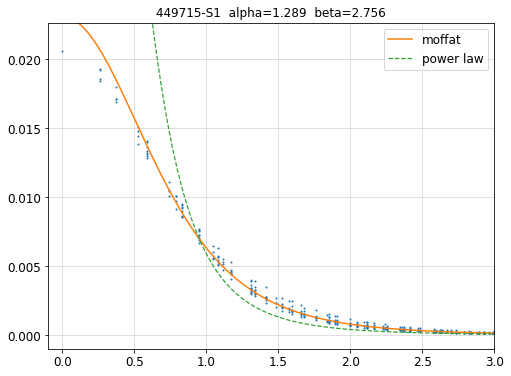

723845 N16 g; FWHM = 1.30


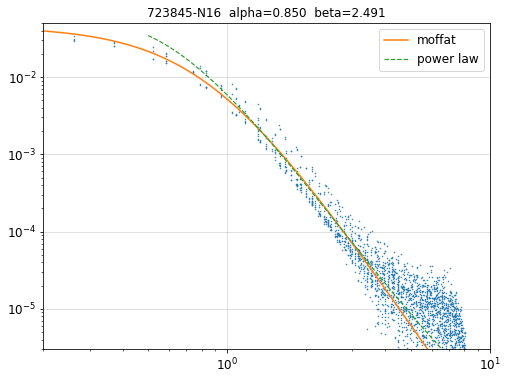

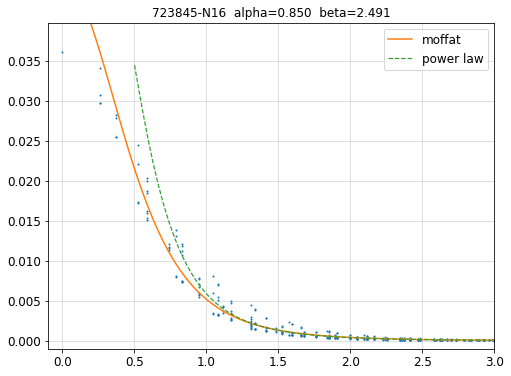

291411 S13 g; FWHM = 1.20


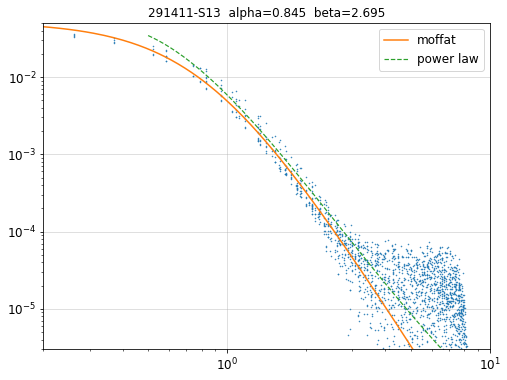

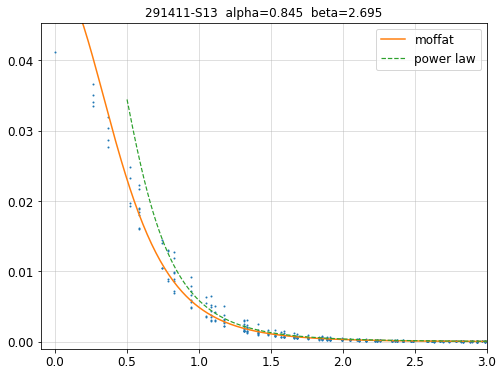

489960 N3 g; FWHM = 1.22


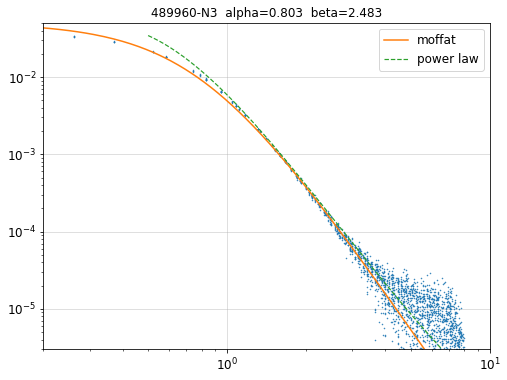

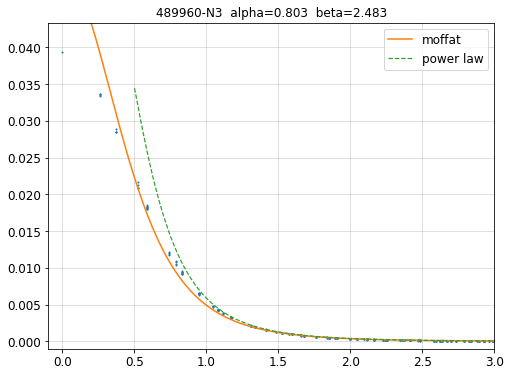

657112 N25 g; FWHM = 1.42


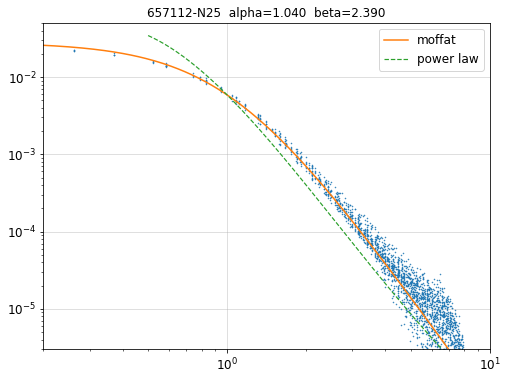

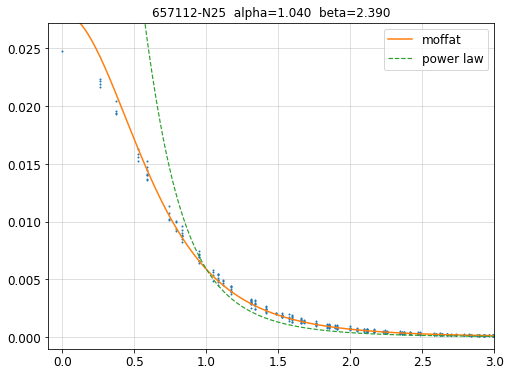

763254 S3 g; FWHM = 1.14


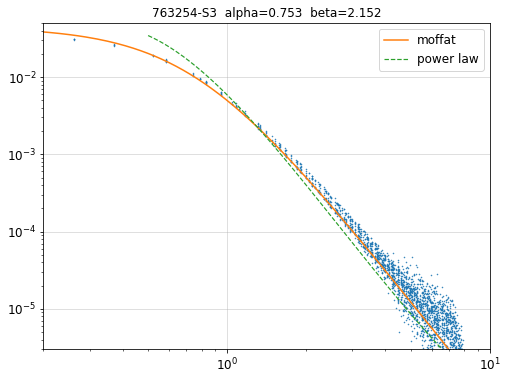

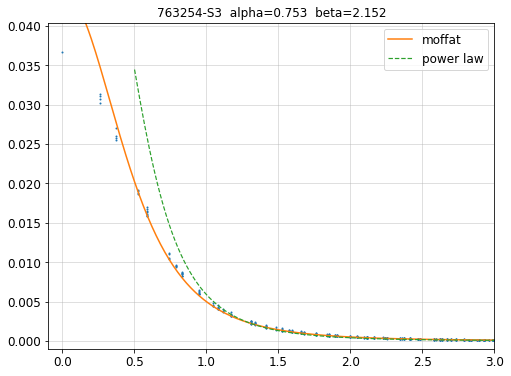

499121 S11 g; FWHM = 1.10


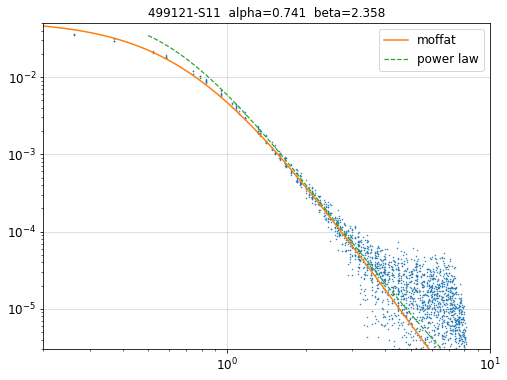

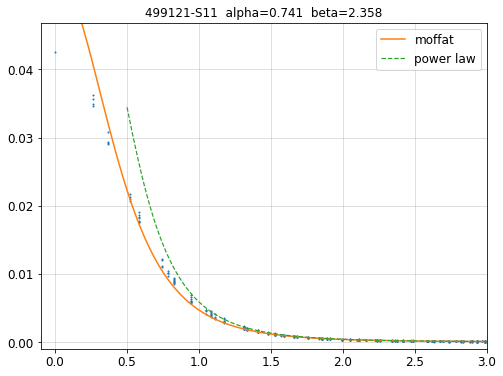

584112 S28 g; FWHM = 1.64


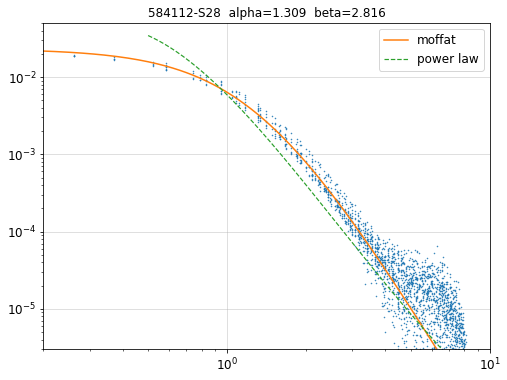

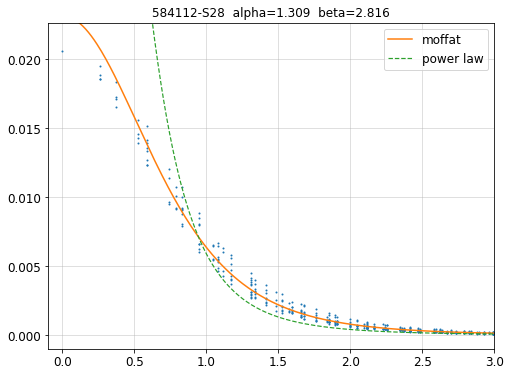

830337 N20 g; FWHM = 1.36


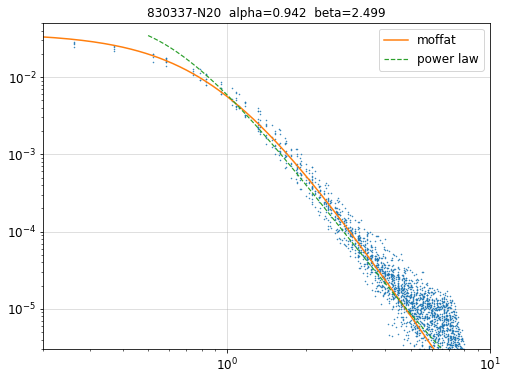

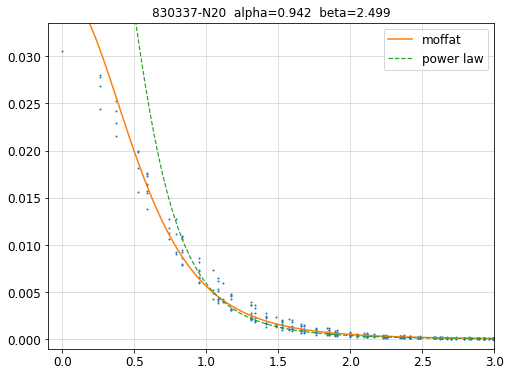

808287 N23 g; FWHM = 1.18


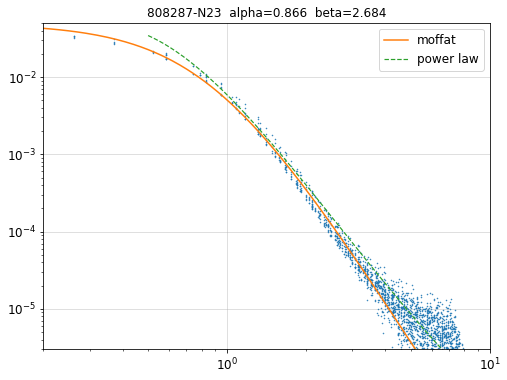

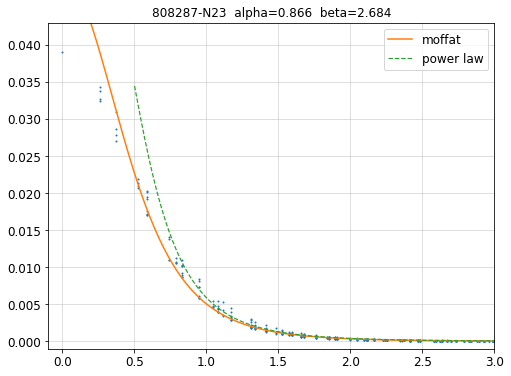

712844 N9 g; FWHM = 1.23


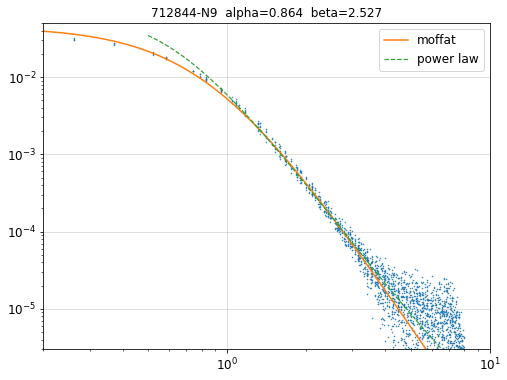

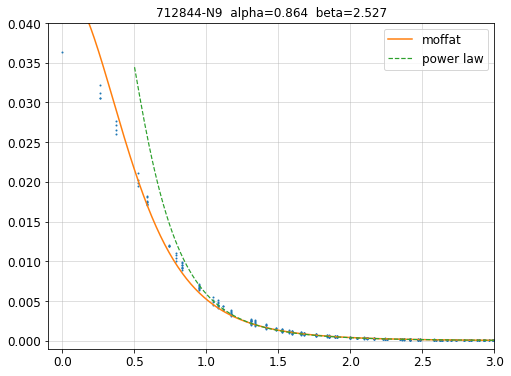

607991 S23 g; FWHM = 1.37


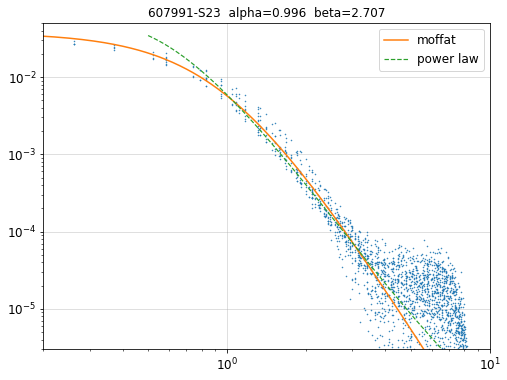

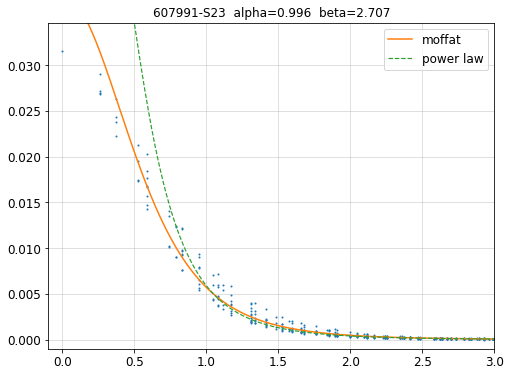

339527 N5 g; FWHM = 0.97


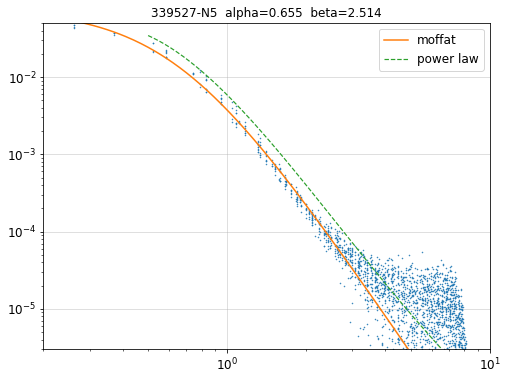

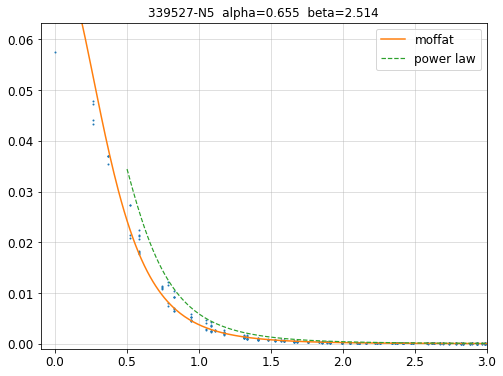

448791 S4 g; FWHM = 1.91


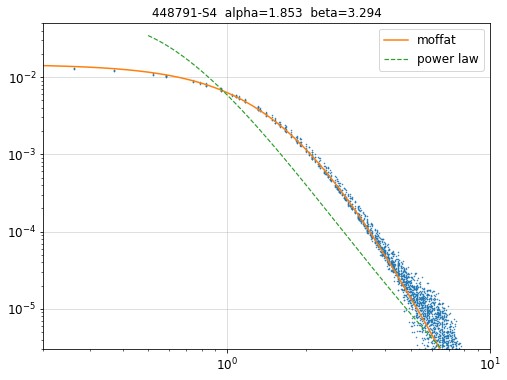

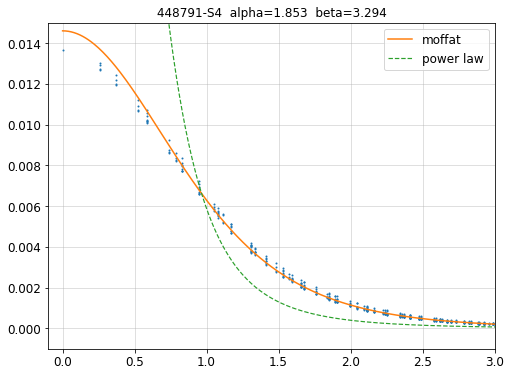

259334 S15 g; FWHM = 1.47


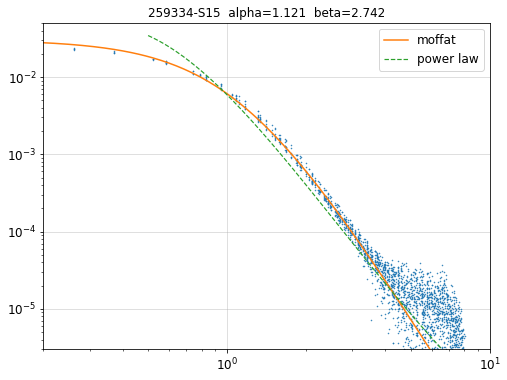

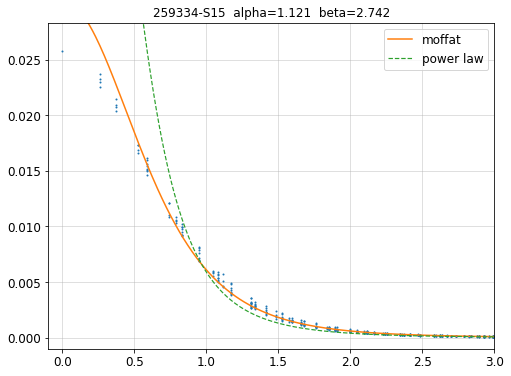

In [16]:
for ccd_index in idx:

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale_native*ccd['fwhm'][ccd_index]))

    expnum_str = str(expnum)
    if field=='south':
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    elif field=='north' and band=='z':
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/mosaic/psfex-merged/{}/mosaic-{}.fits'.format((5-len(expnum_str[:-3]))*'0'+expnum_str[:-3], (8-len(expnum_str))*'0'+expnum_str)
    elif field=='north' and (band=='g' or band=='r'):
        fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/90prime/psfex-merged/{}/90prime-{}.fits'.format(expnum_str[:5], (8-len(expnum_str))*'0'+expnum_str)
    else:
        raise ValueError
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf_all = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf_all[0]
    # normalize to a 22.5 magnitude star
    # print(np.sum(psf0))
    psf0 = psf0/np.sum(psf0)

    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()
    
    ################# Moffat fit ##############
    mask = radius<5.5
    radius_fit = radius[mask]
    psf_fit = (psf0).flatten()[mask]

    radius_arr = np.arange(0, 4.5, 0.2)
    flux_frac = np.zeros(len(radius_arr))
    for index in range(len(radius_arr)):
        flux_frac[index] = np.sum(psf_fit[radius_fit<radius_arr[index]])/np.sum(psf_fit)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        popt, pcov = curve_fit(get_frac_moffat, radius_arr, flux_frac)
        # print(popt)

    alpha, beta = popt
    flux_frac_fit = get_frac_moffat(radius_arr, alpha, beta)
    psf_moffat_fit = pixscale_native**2 * get_sb_moffat(radius_arr, alpha, beta)

    radius_plot = np.linspace(0, 10, 1000)
    psf_moffat_plot = pixscale_native**2 * get_sb_moffat(radius_plot, alpha, beta)
    
    ############################################
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(8, 6))
        plt.loglog(radius, (psf0).flatten(), '.', ms=1.)
        plt.loglog(radius_plot, psf_moffat_plot, '-', label='moffat')
        mask = radius_plot>0.5
        plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], '--', lw=1.2, label='power law')
        plt.axis([0.2, 10, 3e-6, 0.05])
        plt.grid(alpha=0.5)
        plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum, ccdname, alpha, beta))
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(8, 6))
        plt.plot(radius, (psf0).flatten(), '.', ms=2)
        plt.plot(radius_plot, psf_moffat_plot, '-', label='moffat')
        plt.plot(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], '--', lw=1.2, label='power law')
        plt.axis([-0.1, 3, -0.001, 1.1*(psf0).flatten().max()])
        plt.grid(alpha=0.5)
        plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum, ccdname, alpha, beta))
        plt.legend()
        plt.show()